## Import paths

In [1]:
# Paths
import time
import os
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
import math

os.chdir('..')
from pcmf import pcmf_full, path_plot, plot_ordercolor, plot_cluster_assignments, prox_numba_arr, chol_D, SVD, SVD2, get_weights
from p3ca import cluster_metrics, calculate_scores_nonpath

import numpy as np
%load_ext autoreload



## Path plot

In [21]:
from matplotlib import pyplot as plt
def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set()

    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,len(np.unique(true_clusters)) ))
    else:
        colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[1]))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(zip(true_clusters_in,pd.factorize(true_clusters_in)[0])):
                tcc = tc[1]
                tc = tc[0]
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tcc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tcc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tcc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tcc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_facecolor('white')
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
    
def make_plots(A, U, V, S, USV, penalty_list, plot_start=0):
    skip=1

    path_plot(np.mean(np.asarray(A),axis=2)[:,:,np.newaxis][:,::skip,:], penalty_list, plot_range=[plot_start,len(penalty_list)],
              cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
              xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('A mean',fontsize=16)

    path_plot(np.array(A)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[plot_start,len(penalty_list)],
              cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
              xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('A 0',fontsize=16)

    path_plot(np.array(U)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[plot_start,len(penalty_list)],
              cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
              xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('U 0',fontsize=16)

    path_plot(np.array(V)[:,0:4,0:1][:,::skip,:], penalty_list, plot_range=[plot_start,len(penalty_list)],
              cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
              xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('V 0-K',fontsize=16)

    path_plot(np.asarray(USV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('USV 0',fontsize=16)

    path_plot(np.array(S)[:,:][:,:,np.newaxis], penalty_list, plot_range=[5,len(penalty_list)],
              cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
              xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('S',fontsize=16)

    path_plot(np.array(S)[:,1:10][:,:,np.newaxis], penalty_list, plot_range=[5,len(penalty_list)],
              cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
              xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
    plt.locator_params(axis='x',nbins=25)
    plt.ylabel('S 1-K',fontsize=16)

    
    from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog, linear_sum_assignment as linear_assignment

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord


def get_clusters(true_clusters_in, X_in, neighbors, A, UV, USV, U, V, S):
    num_clusters = len(np.unique(true_clusters_in))
    n_X = X_in.shape[1]
    n_Y = X_in.shape[0]
    # NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
    NN = neighbors
    for P in range(len(penalty_list)):
    #     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
        if n_Y < 4000:
    #         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P])) #U[P][:,0:1])) #UV[P]))
    #         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]*np.array(S[P]).flatten()@np.array(V[P])[:,:]))
    #         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]@np.array(V[P])[:,:]))
            spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(A[P])[:,:])
    #         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(X_compB[P])[:,:])
            cs = spectral_clustering.labels_
        else:
            kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
            cs = kmeans.labels_
        import sklearn

        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('Penalty idx',P,'ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in[0:n_Y]), 'ACC',acc)

    if n_Y < 2000:
        # Fit PCMF
        tic=time.time()
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
        toc=time.time() - tic
        cs = spectral_clustering.labels_
        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('X_c spectral','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), 'ACC',acc, 'TOC',toc)

    from sklearn.decomposition import PCA
    tic=time.time()
    pca = PCA(n_components=U[0].shape[1])
    pca_in = pca.fit_transform(X_in[:,0:n_X])
    if n_Y < 2:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
        toc=time.time() - tic
        cs = spectral_clustering.labels_
        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('X_c PCA1 spectral','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    else:
        kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
        toc=time.time() - tic
        cs = kmeans.labels_
        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('X_c PCA1 kmeans','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), 'ACC',acc, 'TOC',toc)

    k = problem_rank
    tic=time.time()
    u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
    pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
    pca_in = (u[:,0:k] @ vh[0:k,:])
    if n_Y < 2:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
        toc=time.time() - tic
        cs = spectral_clustering.labels_
        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('X_c PCA2 spectral','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), 'ACC',acc, 'TOC', toc)
    else:
        kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
        toc=time.time() - tic
        cs = kmeans.labels_
        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('X_c PCA2 kmeans','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), 'ACC',acc, 'TOC',toc)

    kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c kmeans','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), 'ACC',acc, 'TOC',toc)

    if n_Y < 2000:
        from sklearn.cluster import AgglomerativeClustering
        from sklearn.neighbors import kneighbors_graph
        tic=time.time()
        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)
        clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
        toc=time.time() - tic
        cs = clustering.labels_
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
        print('X_c Ward','ARI',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in),'ACC',acc, 'TOC',toc)


    

## Load data

In [3]:
epilepsy_data='NeurIPS2023_experiments/Epilepsy_Data' # data folder should be inside same path as experiment notebook
os.chdir(epilepsy_data)

dirB='Dataset/setb/'
tempB = []
for file in os.listdir(dirB):
    fl = dirB + file
    #creating list of 100 file names belonging to healthy class
    tempB.append(fl)
tempB = sorted(tempB)    

dirD='Dataset/setd/'
tempD = []
for file in os.listdir(dirD):
    fl = dirD + file
    #creating list of 100 file names belonging to preictal class
    tempD.append(fl)
tempD = sorted(tempD)    

dirE='Dataset/sete/'
tempE = []
for file in os.listdir(dirE):
    fl = dirE + file
    #creating list of 100 file names belonging to seizure class
    tempE.append(fl)
tempE = sorted(tempE)


In [4]:
import pandas as pd
def table(table):
    big_table = None
    for ta in table:
        big_table = pd.concat([big_table, ta],axis=1)
    return big_table

tb=[]
st = 'healthy'
for i in range(len(tempB)):

    # read_table loads the value of the file in tempb[i] in variable x
    #datatype of x: dataframe
    #datatype of tb: list

    x = pd.read_table(tempB[i],header=None)
    x.columns=[st+str(i)]
    #print("x:\n",x)
    #tb contains all 4097 datapoints of 100 samples belonging to class 1\healthy
    tb.append(x)
    #print("x value:",x)
eeg_healthy = table(tb).T
print('eeg_healthy',eeg_healthy.shape)

tb=[]
st = 'preictal'
for i in range(len(tempD)):

    # read_table loads the value of the file in tempd[i] in variable x
    #datatype of x: dataframe
    #datatype of tb: list

    x = pd.read_table(tempD[i],header=None)
    x.columns=[st+str(i)]
    #print("x:\n",x)
    #tb contains all 4097 datapoints of 100 samples belonging to class 1\healthy
    tb.append(x)
    #print("x value:",x)
eeg_preictal = table(tb).T
print('eeg_preictal',eeg_preictal.shape)
    
tb=[]
st = 'seizure'
for i in range(len(tempE)):

    # read_table loads the value of the file in tempe[i] in variable x
    #datatype of x: dataframe
    #datatype of tb: list

    x = pd.read_table(tempE[i],header=None)
    x.columns=[st+str(i)]
    #print("x:\n",x)
    #tb contains all 4097 datapoints of 100 samples belonging to class 1\healthy
    tb.append(x)
    #print("x value:",x)

eeg_seizure = table(tb).T
print('eeg_seizure',eeg_seizure.shape)

# eeg_healthy
# eeg_preictal
# eeg_seizure

eeg_all = pd.concat([eeg_healthy,eeg_preictal,eeg_seizure])
eeg_labels = np.repeat(['healthy','preictal','seizure'],100)




eeg_healthy (100, 4097)
eeg_preictal (100, 4097)
eeg_seizure (100, 4097)


## Version 1a

In [5]:
from sklearn.utils.extmath import randomized_svd
def pcmf_full_consensus1a(X_all, penalty_list, problem_rank=1, rho=1.0, admm_iters = 5, verb=False, weights=False, neighbors=None, gauss_coef=2.0,print_progress=True, parallel=False, output_file='NaN',factor_type='SVD', split_size=10):
    '''
    Fits fully constrained PCMF problem iterating between convex clustering and an SVD of rank 'problem_rank' 
    using ADMM updates.
    '''
    print('weights: '+str(weights), 'neighbors: '+str(neighbors), 'gauss_coef: '+str(gauss_coef), 'rho: '+str(rho))
    #
    rho1 = rho2 = rho

    print("rho1:",rho1,"rho2",rho2)
    # Data split
    X_list = np.array_split(X_all, int(X_all.shape[0]/split_size), axis=0) # get batches
    X_list_inds = np.array_split(np.arange(X_all.shape[0]), int(X_all.shape[0]/split_size), axis=0) # get batches
    X = X_list[0]
    num_obs = X.shape[0]
    num_var = X.shape[1]
    D, chol_factor = chol_D(num_obs, num_var, rho1, reg_scale=1.0+rho1) # note num_var is not used in chol_D
    print("Number of batches:",len(X_list))
    #
    # Initialize
    G = []
    A = []
    Z1 = []
    Z2 = []
    U = []
    Vh = []
    s = []
    X_mean = []
    weights_list = []
    for X, idx in zip(X_list, np.arange(len(X_list))):
        print("Initialize IDX:",idx)
        X_mean.append(X.mean(0))
        X = X-np.mean(X,axis=0)
        X_list[idx] = X
        if weights is False:
            weights = get_weights(X,gauss_coef=0.0)
        else:
            weights = get_weights(X,gauss_coef=gauss_coef, neighbors=neighbors)
        weights_list.append(weights)
        #
        Ginit = Z1init = D*X
        Ainit = Z2init = X.copy()
        G.append(Ginit)
        A.append(Ainit)
        Z1.append(Z1init)
        Z2.append(Z2init)
    #
    M = []
    for X, idx in zip(X_list, np.arange(len(X_list))):
        M.append(np.tile(X_mean[idx],(X_list[0].shape[0],1)))
    M = np.vstack(M)
    print("Means matrix has shape:", M.shape)
#     print(M)
    
#     U, s, Vh = SVD(X_all, problem_rank)
    U, s, Vh = randomized_svd(X_all, n_components=problem_rank,random_state=1234)
    for X, idx in zip(X_list, np.arange(len(X_list))):
        X_inds = X_list_inds[idx]
#         Z2[idx] = X_all[X_inds,:] #np.dot(U[X_inds]*s,Vh)
        Z2[idx] = X.copy() #np.dot(U[X_inds]*s,Vh)
    #
    A_list = []
    U_list = []
    s_list = []
    V_list = []
    #
    try:
        # Iterate over penalty grid fitting problem for each value
        for i in range(len(penalty_list)):
            penalty = penalty_list[i]
            num_obs = X.shape[0]
            num_var = X.shape[1]
            if print_progress == True:
                if parallel == True:
                    file1 = open(output_file, "a")
                    file1.write(str([i+1])+" {:.5e}".format(penalty))
                    file1.write("...")
                    file1.close()
                else:                                                     
                    print("[",i+1,"]","{:.5e}".format(penalty), end="")
                    print("...", end="")
            for it in range(admm_iters):
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    A[idx] = chol_factor(X + rho*D.T*(G[idx] - Z1[idx]) + rho*(np.dot(U[X_inds]*s,Vh) - Z2[idx]))
                    G[idx] = prox_numba_arr(np.zeros_like(G[idx]), D*A[idx]+Z1[idx], penalty, rho1, weights_list[idx])
                #
                # consensus
                As = np.vstack(A)
                Z2s = np.vstack(Z2)
                B = As + Z2s
                U_b, s_b, Vh_b = randomized_svd(B, n_components=problem_rank,random_state=1234)
                U_a__s_a = np.dot(B + M, Vh_b.T)
                Vh = Vh_b
                s = s_b
                U = U_a__s_a / s
                U = np.sqrt(1./np.sum(U**2)) * U
                #
                Z2_update = rho2*(As - np.dot(U*s,Vh))
                #
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    Z1[idx] = Z1[idx] + rho1*(D*A[idx] - G[idx])
                    Z2[idx] = Z2[idx] + Z2_update[X_inds,:]

            A_list.append(np.vstack(A))
            V_list.append(np.vstack(Vh))
            s_list.append(s)
            U_list.append(np.vstack(U))
            
    except KeyboardInterrupt:
        print("KeyboardInterrupt has been caught.")
        
    return A_list, U_list, s_list, V_list



## Version 1b

In [6]:
from sklearn.utils.extmath import randomized_svd
def pcmf_full_consensus1b(X_all, penalty_list, problem_rank=1, rho=1.0, admm_iters = 5, verb=False, weights=False, neighbors=None, gauss_coef=2.0,print_progress=True, parallel=False, output_file='NaN',factor_type='SVD', split_size=10):
    '''
    Fits fully constrained PCMF problem iterating between convex clustering and an SVD of rank 'problem_rank' 
    using ADMM updates.
    '''
    print('weights: '+str(weights), 'neighbors: '+str(neighbors), 'gauss_coef: '+str(gauss_coef), 'rho: '+str(rho))
    #
    rho1 = rho2 = rho

    print("rho1:",rho1,"rho2",rho2)
    # Data split
    X_list = np.array_split(X_all, int(X_all.shape[0]/split_size), axis=0) # get batches
    X_list_inds = np.array_split(np.arange(X_all.shape[0]), int(X_all.shape[0]/split_size), axis=0) # get batches
    X = X_list[0]
    num_obs = X.shape[0]
    num_var = X.shape[1]
    D, chol_factor = chol_D(num_obs, num_var, rho1, reg_scale=1.0+rho1) # note num_var is not used in chol_D
    print("Number of batches:",len(X_list))
    #
    # Initialize
    G = []
    A = []
    Z1 = []
    Z2 = []
    U = []
    Vh = []
    s = []
    X_mean = []
    weights_list = []

    U, s, Vh = SVD2(X_all, problem_rank)
    Vhorig = Vh

    for X, idx in zip(X_list, np.arange(len(X_list))):
        print("Initialize IDX:",idx)
        X_mean.append(X.mean(0))
        X = X-np.mean(X,axis=0)
        X_list[idx] = X
        if weights is False:
            weights = get_weights(X,gauss_coef=0.0)
        else:
            weights = get_weights(X,gauss_coef=gauss_coef, neighbors=neighbors)
        weights_list.append(weights)
        #
        Ginit = Z1init = D*X
        Ainit = Z2init = X.copy()
        
        Ginit = np.zeros_like(Ginit)
        Z1init = np.zeros_like(Z1init)
        
        G.append(Ginit)
        A.append(Ainit)
        Z1.append(Z1init)
        Z2.append(Z2init)
    #
    M = []
    for X, idx in zip(X_list, np.arange(len(X_list))):
        M.append(np.tile(X_mean[idx],(X_list[0].shape[0],1)))
    M = np.vstack(M)
    print("Means matrix has shape:", M.shape)
#     print(M)
    
    for X, idx in zip(X_list, np.arange(len(X_list))):
        X_inds = X_list_inds[idx]
        A[idx] = np.dot(U[X_inds]*s,Vh)
        Z2[idx] = np.dot(U[X_inds]*s,Vh)
    
    #
    A_list = []
    U_list = []
    s_list = []
    V_list = []
    #
    try:
        # Iterate over penalty grid fitting problem for each value
        for i in range(len(penalty_list)):
            penalty = penalty_list[i]
            num_obs = X.shape[0]
            num_var = X.shape[1]
            if print_progress == True:
                if parallel == True:
                    file1 = open(output_file, "a")
                    file1.write(str([i+1])+" {:.5e}".format(penalty))
                    file1.write("...")
                    file1.close()
                else:                                                     
                    print("[",i+1,"]","{:.5e}".format(penalty), end="")
                    print("...", end="")
            for it in range(admm_iters):
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    A[idx] = chol_factor(X + rho*D.T*(G[idx] - Z1[idx]) + rho*(np.dot(U[X_inds]*s,Vh) - Z2[idx]))
                    G[idx] = prox_numba_arr(np.zeros_like(G[idx]), D*A[idx]+Z1[idx], penalty, rho1, weights_list[idx])
                #
                # consensus
                As = np.vstack(A)
                Z2s = np.vstack(Z2)
                B = As + Z2s
                U_b, s_b, Vh_b = SVD2(B, problem_rank)
                U_a__s_a = np.dot(B + M, Vh_b.T)
                Vh = Vh_b
                s = s_b
                U = U_a__s_a / s
                U = np.sqrt(1./np.sum(U**2)) * U
#
                if problem_rank > 0:
                    for k in range(0,problem_rank):
                        if np.round(s[k],1)<=0.2:
                            U[:,k] = 0
                            Vh[k,:] = 0
                            s[k] = 0
                        if penalty==np.inf:
                            U[:,k] = 0
                            Vh[k,:] = 0
                            s[k] = 0
                        if np.sign(Vh[k,0]) == -1:
                            U[:,k] = U[:,k] * -1
                            Vh[k,:] = Vh[k,:] * -1

                Z2_update = rho2*(As - np.dot(U*s,Vh))
                #
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    Z1[idx] = Z1[idx] + rho1*(D*A[idx] - G[idx])
                    Z2[idx] = Z2[idx] + Z2_update[X_inds,:]

            A_list.append(np.vstack(A))
            V_list.append(np.vstack(Vh))
            s_list.append(s)
            U_list.append(np.vstack(U))
            
    except KeyboardInterrupt:
        print("KeyboardInterrupt has been caught.")
        
    return A_list, U_list, s_list, V_list



## Version 2

In [7]:
from sklearn.utils.extmath import randomized_svd

def pcmf_full_consensus2(X_all, penalty_list, problem_rank=1, rho=1.0, admm_iters = 5, verb=False, weights=False, neighbors=None, gauss_coef=2.0,print_progress=True, parallel=False, output_file='NaN',factor_type='SVD', split_size=10):
    '''
    Fits fully constrained PCMF problem iterating between convex clustering and an SVD of rank 'problem_rank' 
    using ADMM updates.
    '''
    print('weights: '+str(weights), 'neighbors: '+str(neighbors), 'gauss_coef: '+str(gauss_coef), 'rho: '+str(rho))
    #
    rho1 = rho2 = rho

    print("rho1:",rho1,"rho2",rho2)
    # Data split
    X_list = np.array_split(X_all, int(X_all.shape[0]/split_size), axis=0) # get batches
    X_list_inds = np.array_split(np.arange(X_all.shape[0]), int(X_all.shape[0]/split_size), axis=0) # get batches
    X = X_list[0]
    num_obs = X.shape[0]
    num_var = X.shape[1]
    D, chol_factor = chol_D(num_obs, num_var, rho1, reg_scale=1.0+rho1) # note num_var is not used in chol_D
    print("Number of batches:",len(X_list))
    #
    # Initialize
    G = []
    A = []
    Z1 = []
    Z2 = []
    U = []
    Vh = []
    s = []
    Us = []
    ss = []
    Vhs = []
    Vhs2 = []
    X_mean = []
    weights_list = []

    U, s, Vh = SVD2(X_all, problem_rank)
    Uorig = U
    Sorig = s
    Vhorig = Vh
    
    for X, idx in zip(X_list, np.arange(len(X_list))):
        print("Initialize IDX:",idx)
        X_mean.append(X.mean(0))
#         X = X-np.mean(X,axis=0)
        X_list[idx] = X
        if weights is False:
            weights = get_weights(X,gauss_coef=0.0)
        else:
            weights = get_weights(X,gauss_coef=gauss_coef, neighbors=neighbors)
        weights_list.append(weights)
        #
        Ginit = Z1init = D*X
#         Ainit = Z2init = X.copy()
#         Ainit = Z2init = np.vstack([np.mean(X_all,axis=0)]*num_obs)
        Ainit = Z2init = np.vstack([np.mean(X, axis=0)]*num_obs) # A is set to mean Xbatch
     
        X_inds = X_list_inds[idx]
        
        U, s, Vh = SVD2(Uorig[X_inds,:]*Sorig - np.mean(Uorig[X_inds,:]*Sorig,axis=0), problem_rank) # Vh is now Abatch
        signSwitcher = np.sign(np.diag(Vh))
        print(Vh.shape)
        for k in np.arange(problem_rank):
            Vh[k,:] = (signSwitcher[k]*Vh[k,:].T).T
            U[:,k] = (signSwitcher[k]*U[:,k])
        
        G.append(Ginit)
        A.append(Ainit)
        Z1.append(Z1init)
        Z2.append(Z2init)
#         Us.append(U[X_inds,:])
        Us.append(U)
        ss.append(s)
        Vhs.append(Vh)
        Vhs2.append(np.dot(Vh.T,Vhorig))
        print(Vh.shape)
    #
    A_list = []
    U_list = []
    s_list = []
    V_list = []
    #
    Sorig1=Sorig
    try:
        # Iterate over penalty grid fitting problem for each value
        for i in range(len(penalty_list)):
            penalty = penalty_list[i]
            num_obs = X.shape[0]
            num_var = X.shape[1]
            if print_progress == True:
                if parallel == True:
                    file1 = open(output_file, "a")
                    file1.write(str([i+1])+" {:.5e}".format(penalty))
                    file1.write("...")
                    file1.close()
                else:                                                     
                    print("[",i+1,"]","{:.5e}".format(penalty), end="")
                    print("...", end="")
            for it in range(admm_iters):
                # BATCHES
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
#                     A[idx] = chol_factor(X + rho*D.T*(G[idx] - Z1[idx]) + rho*(np.dot(Us[idx]*Sorig, np.dot(Vhs[idx].T,Vhorig)) - Z2[idx]) ) 
#                     A[idx] = chol_factor(X + rho*D.T*(G[idx] - Z1[idx]) + rho*(np.dot(Us[idx]*np.mean(ss,axis=0), np.dot(Vhs[idx].T,Vhorig)) - Z2[idx]) ) 
                    A[idx] = chol_factor(X + rho*D.T*(G[idx] - Z1[idx]) + rho*(np.dot(Us[idx]*ss[idx], np.dot(Vhs[idx].T,Vhorig)) - Z2[idx]) ) 
                    G[idx] = prox_numba_arr(np.zeros_like(G[idx]), D*A[idx]+Z1[idx], penalty, rho1, weights_list[idx])
                    
                U, s, Vh = SVD2( (np.vstack(A) + np.vstack(Z2)) - np.mean((np.vstack(A) + np.vstack(Z2)),axis=0) , problem_rank)
                Uorig1 = U
                Sorig1 = s
                Vhorig1 = Vh
                
                for X, idx in zip(X_list, np.arange(len(X_list))):
                    X_inds = X_list_inds[idx]
                    U, s, Vh = SVD2(Uorig1[X_inds,:]*Sorig1 - np.mean(Uorig1[X_inds,:]*Sorig1,axis=0), problem_rank) # Vh is now Abatch
                    signSwitcher = np.sign(np.diag(Vh))
                    for k in np.arange(problem_rank):
                        Vh[k,:] = (signSwitcher[k]*Vh[k,:].T).T
                        U[:,k] = (signSwitcher[k]*U[:,k])
                
                    Us[idx] = U
                    ss[idx] = s
                    Vhs[idx] = Vh
                    Vhs2[idx] = np.dot(Vhs[idx].T,Vhorig)
                
#                 Z2_update = rho2*(np.vstack(A) - np.dot(np.vstack(Us)*Sorig, np.dot(np.mean(Vhs,axis=0).T,Vhorig)) )
                Z2_update = rho2*(np.vstack(A) - np.dot(np.vstack(Us)*np.mean(ss,axis=0), np.dot(np.mean(Vhs,axis=0).T,Vhorig)) )
                for X, idx in zip(X_list, np.arange(len(X_list))):
#                     Z2_update = rho2*(np.vstack(A) - np.dot(np.vstack(Us)*Sorig, np.dot(Vhs[idx].T,Vhorig)) )
#                     Z2_update = rho2*(np.vstack(A) - np.dot(np.vstack(Us)*ss[idx], np.dot(Vhs[idx].T,Vhorig)) )
                    X_inds = X_list_inds[idx]
                    Z2[idx] = Z2[idx] + Z2_update[X_inds,:]
                    Z1[idx] = Z1[idx] + rho1*(D*A[idx] - G[idx])
            

            A_list.append(np.vstack(A))
            s_list.append(np.mean(ss,axis=0))
#                 s_list.append(Sorig1))
#                 s_list.append(Sorig)
            U_list.append(np.vstack(Us))
            V_list.append(np.vstack(np.mean(Vhs2,axis=0)))

            
    except KeyboardInterrupt:
        print("KeyboardInterrupt has been caught.")
        
    return A_list, U_list, s_list, V_list



## Experiment 1 - PCMF full

In [14]:
### SELECT THE DATA

X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_seizure)))
true_clusters_in = np.repeat([0,2],100) #pd.factorize(eeg_labels)[0]
true_clusters_in_lbls = ['healthy','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),(np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([0,1,2],100) #pd.factorize(eeg_labels)[0]
# true_clusters_in_lbls = ['healthy','preictal','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_preictal)))
# true_clusters_in = np.repeat([0,1],100)
# true_clusters_in_lbls = ['healthy','preictal']

# X_in = np.vstack((np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([1,2],100)
# true_clusters_in_lbls = ['preictal','seizure']


# STANDARDIZE DATA
scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
X_in = scaler.transform(X_in)
normalizer = Normalizer().fit(X_in)
X_in = normalizer.transform(X_in)
scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
X_in = scaler2.transform(X_in)

# X_in_test = scaler.transform(X_in_test)
# X_in_test = normalizer.transform(X_in_test)
# X_in_test = scaler2.transform(X_in_test)

# print('Clusters',true_clusters_in.shape,X_in.shape[0])

# SUBSAMPLE
X_in = X_in[::2,:]
true_clusters_in = true_clusters_in[::2]
# print('Clusters',true_clusters_in.shape, X_in.shape[0])

# RANDOMIZE INDICES
idxs = np.random.RandomState(seed=0).permutation(X_in.shape[0])
X_in = X_in[idxs,:]
true_clusters_in = true_clusters_in[idxs]
print(X_in.shape, true_clusters_in.shape)

print('Clusters',true_clusters_in)

# PARAMETERS
batch_size = X_in.shape[0]/4
# penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(0,10,300))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(0,5,10))[::-1]),axis=0)
gc = 2 #0.5
admm_iters = 5
neighbors = 20
rho = 1
problem_rank = 3


(100, 4097) (100,)
Clusters [0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 2 2 2 2 2 2 2 0 0
 2 2 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 2 2 2 2 0 2 0 2 0 0 0 2
 2 2 0 2 2 2 0 0 2 0 0 2 2 0 2 2 2 0 0 2 0 2 2 2 0 0]


In [15]:
print('Problem rank',problem_rank)
# Fit PCMF
tic=time.time()
A_list, U_list, s_list, V_list = pcmf_full(X_in, penalty_list, numba=True, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
# A_list, U_list, s_list, V_list = pcmf_consensus1a(X_in, penalty_list, numba=True, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
# A_list, U_list, s_list, V_list = pcmf_consensus1b(X_in, penalty_list, numba=True, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
# A_list, U_list, s_list, V_list = pcmf_consensus1c(X_in, penalty_list, numba=True, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
toc=time.time() - tic


Problem rank 3
weights: Gaussian neighbors: 20 gauss_coef: 2 rho: 1
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 8.51526e+01...[ 13 ] 4.88566e+01...[ 14 ] 2.80316e+01...[ 15 ] 1.60832e+01...[ 16 ] 9.22781e+00...[ 17 ] 5.29449e+00...[ 18 ] 3.03773e+00...[ 19 ] 1.74291e+00...[ 20 ] 1.00000e+00...

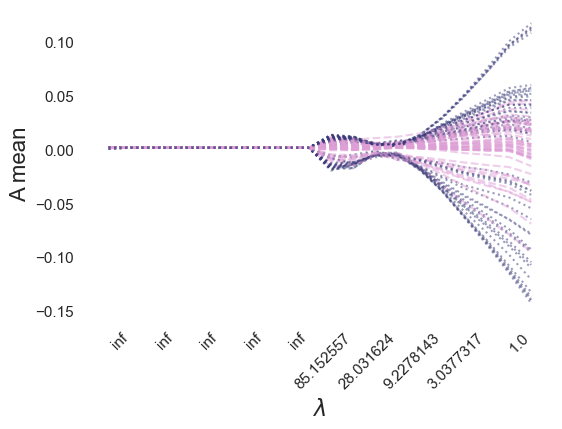

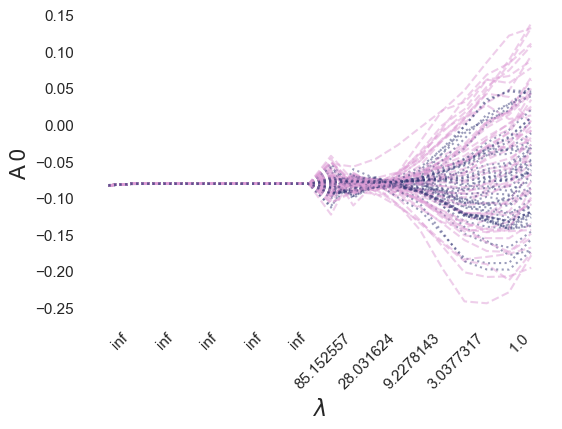

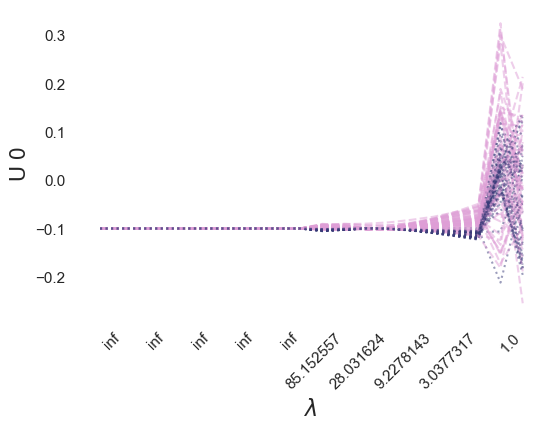

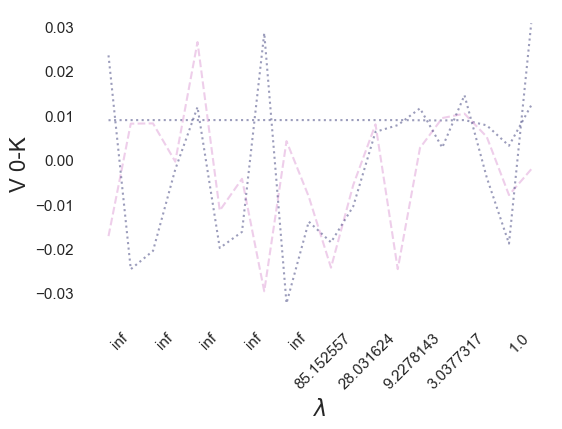

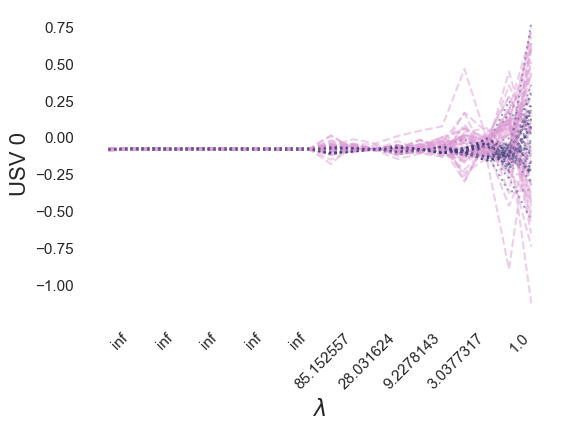

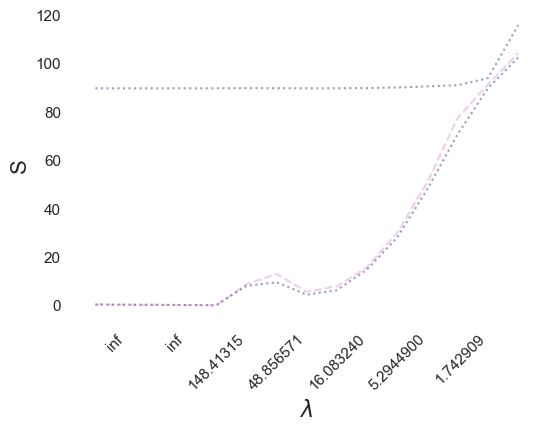

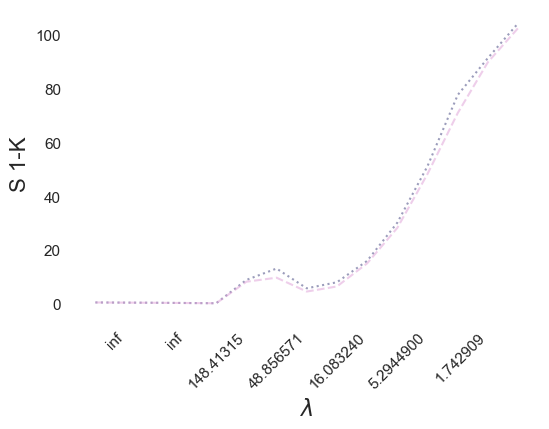

In [16]:
A = A_list
U = U_list
S = s_list
V = V_list

X_compA = []
X_compB = []
UV = []
USV = []
for p in range(len(penalty_list)):
    x_pcmf = U[p]*S[p][:]
    x_pcmf2 = (X_in[:,:] @ V[p].T) 
    X_compA.append(np.array(x_pcmf))
    X_compB.append(np.array(x_pcmf2))
    UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
    USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

X_compA=np.asarray(X_compA)
X_compB=np.asarray(X_compB)

make_plots(A, U, V, S, USV, penalty_list, plot_start=0)


In [22]:
get_clusters(true_clusters_in, X_in, neighbors, A, UV, USV, U, V, S)


Penalty idx 0 ARI 0.6364749082007344 ACC 0.9
Penalty idx 1 ARI -0.009466258094262714 ACC 0.51
Penalty idx 2 ARI -0.009103924231856393 ACC 0.51
Penalty idx 3 ARI -0.009103924231856393 ACC 0.51
Penalty idx 4 ARI -0.0058734995044234795 ACC 0.53
Penalty idx 5 ARI -0.010138113429327064 ACC 0.5
Penalty idx 6 ARI 0.005657823938954199 ACC 0.56
Penalty idx 7 ARI -0.0036732295033793712 ACC 0.54
Penalty idx 8 ARI 0.009923249864330567 ACC 0.57
Penalty idx 9 ARI -0.00817625458996328 ACC 0.52
Penalty idx 10 ARI 0.040417045236940854 ACC 0.61
Penalty idx 11 ARI 0.04986068338466051 ACC 0.62
Penalty idx 12 ARI 0.040417045236940854 ACC 0.61
Penalty idx 13 ARI 0.040417045236940854 ACC 0.61
Penalty idx 14 ARI 0.040417045236940854 ACC 0.61
Penalty idx 15 ARI 0.040417045236940854 ACC 0.61
Penalty idx 16 ARI 0.040417045236940854 ACC 0.61
Penalty idx 17 ARI 0.040417045236940854 ACC 0.61
Penalty idx 18 ARI 0.06011509842014589 ACC 0.63
Penalty idx 19 ARI 0.06011509842014589 ACC 0.63
X_c spectral ARI 0.0498606833

## Experiment 2 - PCMF consensus 1A

In [26]:
### SELECT THE DATA

X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_seizure)))
true_clusters_in = np.repeat([0,2],100) #pd.factorize(eeg_labels)[0]
true_clusters_in_lbls = ['healthy','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),(np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([0,1,2],100) #pd.factorize(eeg_labels)[0]
# true_clusters_in_lbls = ['healthy','preictal','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_preictal)))
# true_clusters_in = np.repeat([0,1],100)
# true_clusters_in_lbls = ['healthy','preictal']


# X_in = np.vstack((np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([1,2],100)
# true_clusters_in_lbls = ['preictal','seizure']


# STANDARDIZE DATA
scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
X_in = scaler.transform(X_in)
normalizer = Normalizer().fit(X_in)
X_in = normalizer.transform(X_in)
scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
X_in = scaler2.transform(X_in)

# X_in_test = scaler.transform(X_in_test)
# X_in_test = normalizer.transform(X_in_test)
# X_in_test = scaler2.transform(X_in_test)

# print('Clusters',true_clusters_in.shape,X_in.shape[0])

# SUBSAMPLE
X_in = X_in[::2,:]
true_clusters_in = true_clusters_in[::2]
# print('Clusters',true_clusters_in.shape, X_in.shape[0])

# RANDOMIZE INDICES
idxs = np.random.RandomState(seed=0).permutation(X_in.shape[0])
X_in = X_in[idxs,:]
true_clusters_in = true_clusters_in[idxs]
print(X_in.shape, true_clusters_in.shape)

print('Clusters',true_clusters_in)

# PARAMETERS
batch_size = X_in.shape[0]/4
# penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(0,10,300))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(0,5,10))[::-1]),axis=0)
gc = 2 #0.5
admm_iters = 5
neighbors = 20
rho = 1
problem_rank = 3




(100, 4097) (100,)
Clusters [0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 2 2 2 2 2 2 2 0 0
 2 2 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 2 2 2 2 0 2 0 2 0 0 0 2
 2 2 0 2 2 2 0 0 2 0 0 2 2 0 2 2 2 0 0 2 0 2 2 2 0 0]


In [27]:
print('Problem rank',problem_rank)
# Fit PCMF
tic=time.time()
A_list, U_list, s_list, V_list = pcmf_full_consensus1a(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
toc=time.time() - tic


Problem rank 3
weights: Gaussian neighbors: 20 gauss_coef: 2 rho: 1
rho1: 1 rho2 1
Number of batches: 4
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Means matrix has shape: (100, 4097)
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 8.51526e+01...[ 13 ] 4.88566e+01...[ 14 ] 2.80316e+01...[ 15 ] 1.60832e+01...[ 16 ] 9.22781e+00...[ 17 ] 5.29449e+00...[ 18 ] 3.03773e+00...[ 19 ] 1.74291e+00...[ 20 ] 1.00000e+00...

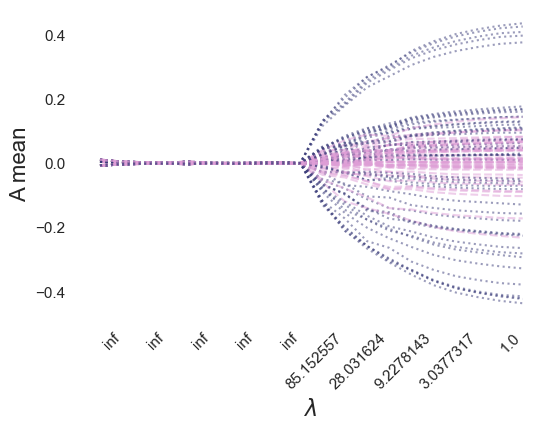

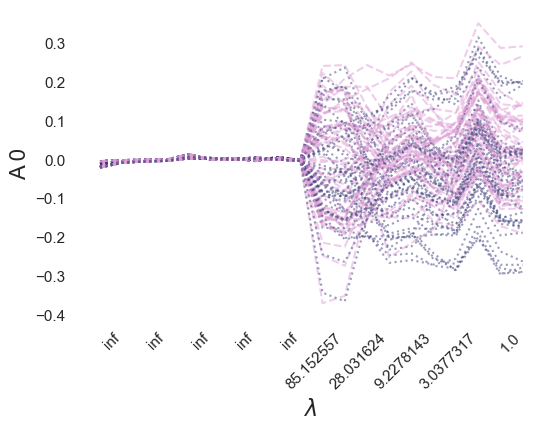

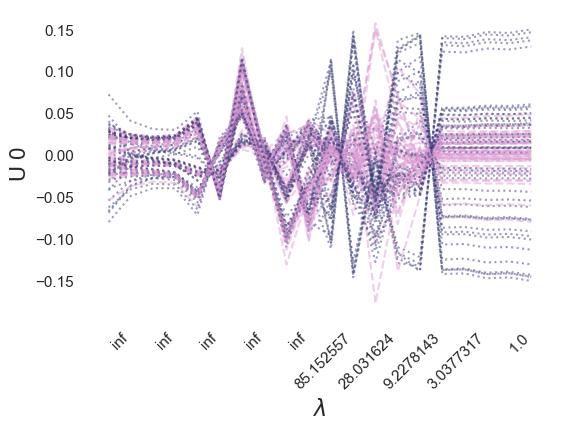

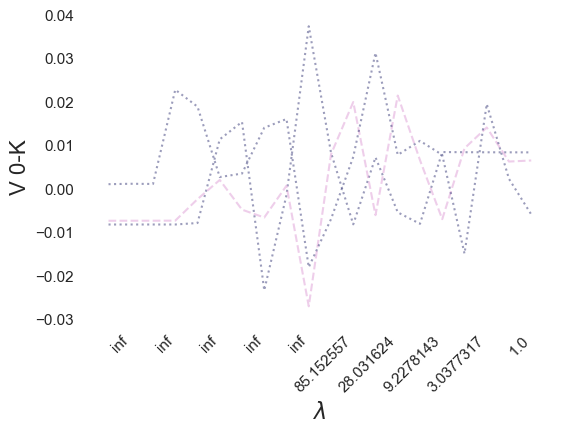

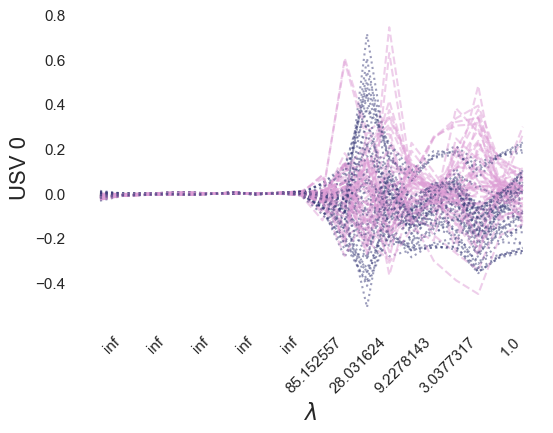

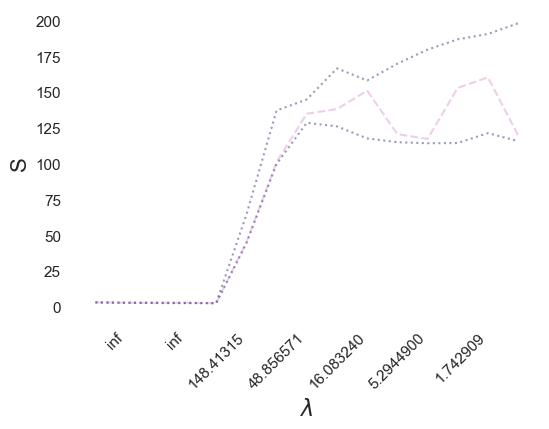

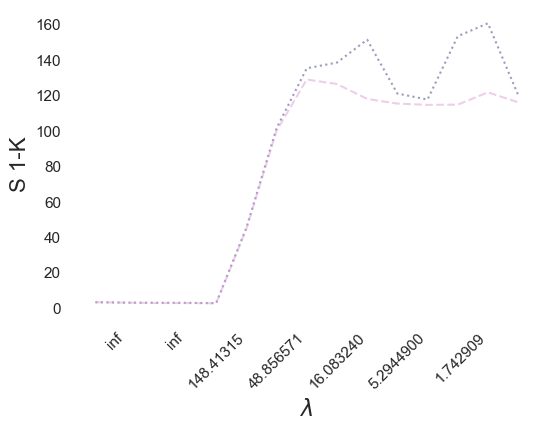

In [28]:
A = A_list
U = U_list
S = s_list
V = V_list

X_compA = []
X_compB = []
UV = []
USV = []
for p in range(len(penalty_list)):
    x_pcmf = U[p]*S[p][:]
    x_pcmf2 = (X_in[:,:] @ V[p].T) 
    X_compA.append(np.array(x_pcmf))
    X_compB.append(np.array(x_pcmf2))
    UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
    USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

X_compA=np.asarray(X_compA)
X_compB=np.asarray(X_compB)

make_plots(A, U, V, S, USV, penalty_list, plot_start=0)


In [29]:
get_clusters(true_clusters_in, X_in, neighbors, A, UV, USV, U, V, S)


Penalty idx 0 ARI -0.008587755102040816 ACC 0.52
Penalty idx 1 ARI -0.007230534351145038 ACC 0.51
Penalty idx 2 ARI -0.007230534351145038 ACC 0.51
Penalty idx 3 ARI -0.007230534351145038 ACC 0.51
Penalty idx 4 ARI -0.0040061068702290075 ACC 0.53
Penalty idx 5 ARI -0.007230534351145038 ACC 0.51
Penalty idx 6 ARI -0.007230534351145038 ACC 0.51
Penalty idx 7 ARI -0.0040061068702290075 ACC 0.53
Penalty idx 8 ARI -0.008587755102040816 ACC 0.52
Penalty idx 9 ARI -0.008587755102040816 ACC 0.52
Penalty idx 10 ARI 0.05060323352708445 ACC 0.62
Penalty idx 11 ARI 0.7026396121386246 ACC 0.92
Penalty idx 12 ARI 0.30731969860064584 ACC 0.78
Penalty idx 13 ARI 0.3075116988146288 ACC 0.78
Penalty idx 14 ARI 0.263724434876211 ACC 0.76
Penalty idx 15 ARI 0.3306148898969274 ACC 0.79
Penalty idx 16 ARI 0.3075116988146288 ACC 0.78
Penalty idx 17 ARI 0.263724434876211 ACC 0.76
Penalty idx 18 ARI 0.28521458361361496 ACC 0.77
Penalty idx 19 ARI 0.3075116988146288 ACC 0.78
X_c spectral ARI 0.04986068338466051 

## Experiment 3 - PCMF consensus 1b

In [30]:
### SELECT THE DATA

X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_seizure)))
true_clusters_in = np.repeat([0,2],100) #pd.factorize(eeg_labels)[0]
true_clusters_in_lbls = ['healthy','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),(np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([0,1,2],100) #pd.factorize(eeg_labels)[0]
# true_clusters_in_lbls = ['healthy','preictal','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_preictal)))
# true_clusters_in = np.repeat([0,1],100)
# true_clusters_in_lbls = ['healthy','preictal']

# X_in = np.vstack((np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([1,2],100)
# true_clusters_in_lbls = ['preictal','seizure']


# STANDARDIZE DATA
scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
X_in = scaler.transform(X_in)
normalizer = Normalizer().fit(X_in)
X_in = normalizer.transform(X_in)
scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
X_in = scaler2.transform(X_in)

# X_in_test = scaler.transform(X_in_test)
# X_in_test = normalizer.transform(X_in_test)
# X_in_test = scaler2.transform(X_in_test)

# print('Clusters',true_clusters_in.shape,X_in.shape[0])

# SUBSAMPLE
X_in = X_in[::2,:]
true_clusters_in = true_clusters_in[::2]
# print('Clusters',true_clusters_in.shape, X_in.shape[0])

# RANDOMIZE INDICES
idxs = np.random.RandomState(seed=0).permutation(X_in.shape[0])
X_in = X_in[idxs,:]
true_clusters_in = true_clusters_in[idxs]
print(X_in.shape, true_clusters_in.shape)

print('Clusters',true_clusters_in)

# PARAMETERS
batch_size = X_in.shape[0]/4
# penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(0,10,300))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(0,5,10))[::-1]),axis=0)
gc = 2 #0.5
admm_iters = 5
neighbors = 20
rho = 1
problem_rank = 3




(100, 4097) (100,)
Clusters [0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 2 2 2 2 2 2 2 0 0
 2 2 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 2 2 2 2 0 2 0 2 0 0 0 2
 2 2 0 2 2 2 0 0 2 0 0 2 2 0 2 2 2 0 0 2 0 2 2 2 0 0]


In [31]:
print('Problem rank',problem_rank)
# Fit PCMF
tic=time.time()
A_list, U_list, s_list, V_list = pcmf_full_consensus1b(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
toc=time.time() - tic


Problem rank 3
weights: Gaussian neighbors: 20 gauss_coef: 2 rho: 1
rho1: 1 rho2 1
Number of batches: 4
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Means matrix has shape: (100, 4097)
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 8.51526e+01...[ 13 ] 4.88566e+01...[ 14 ] 2.80316e+01...[ 15 ] 1.60832e+01...[ 16 ] 9.22781e+00...[ 17 ] 5.29449e+00...[ 18 ] 3.03773e+00...[ 19 ] 1.74291e+00...[ 20 ] 1.00000e+00...

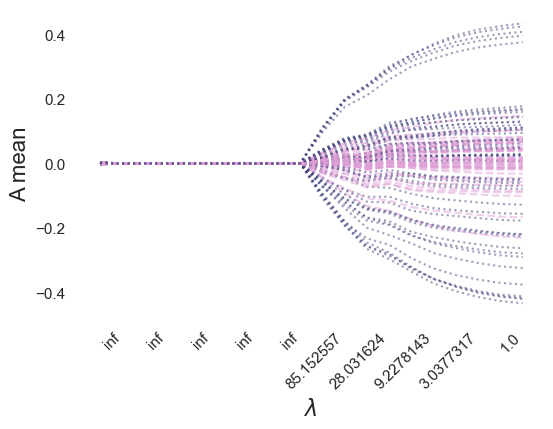

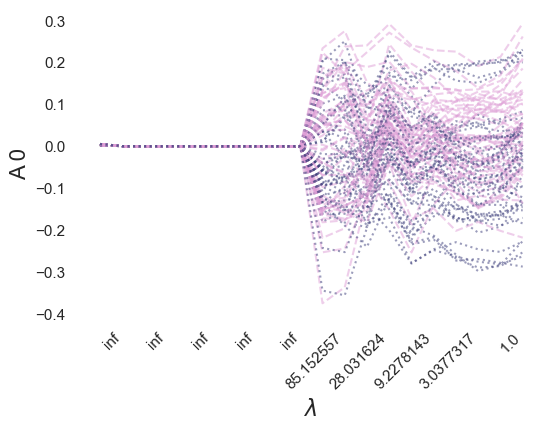

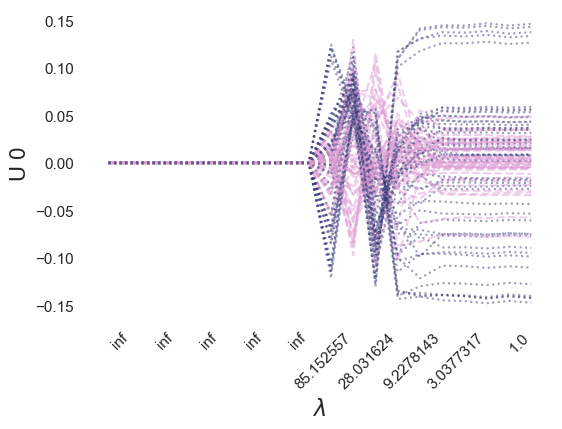

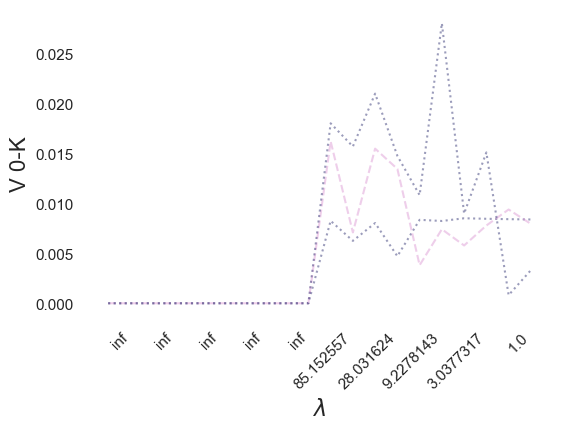

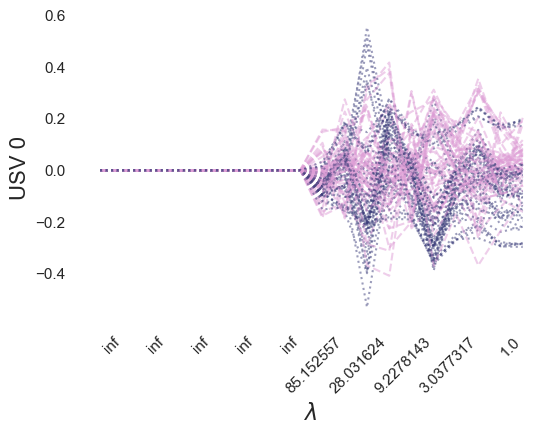

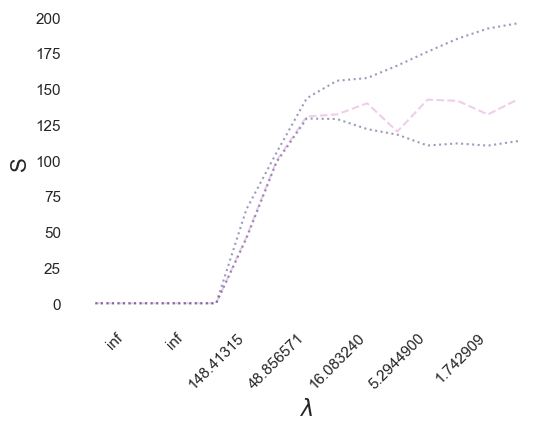

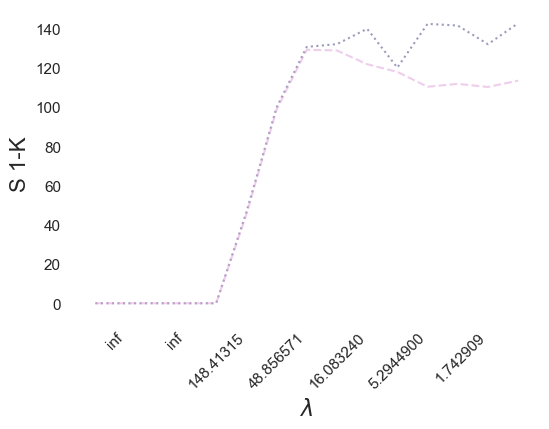

In [32]:
A = A_list
U = U_list
S = s_list
V = V_list

X_compA = []
X_compB = []
UV = []
USV = []
for p in range(len(penalty_list)):
    x_pcmf = U[p]*S[p][:]
    x_pcmf2 = (X_in[:,:] @ V[p].T) 
    X_compA.append(np.array(x_pcmf))
    X_compB.append(np.array(x_pcmf2))
    UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
    USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

X_compA=np.asarray(X_compA)
X_compB=np.asarray(X_compB)

make_plots(A, U, V, S, USV, penalty_list, plot_start=0)


In [33]:
get_clusters(true_clusters_in, X_in, neighbors, A, UV, USV, U, V, S)


Penalty idx 0 ARI -0.008587755102040816 ACC 0.52
Penalty idx 1 ARI -0.008587755102040816 ACC 0.52
Penalty idx 2 ARI -0.007230534351145038 ACC 0.51
Penalty idx 3 ARI -0.008587755102040816 ACC 0.52
Penalty idx 4 ARI -0.007230534351145038 ACC 0.51
Penalty idx 5 ARI -0.008587755102040816 ACC 0.52
Penalty idx 6 ARI -0.007230534351145038 ACC 0.51
Penalty idx 7 ARI -0.0040061068702290075 ACC 0.53
Penalty idx 8 ARI -0.008587755102040816 ACC 0.52
Penalty idx 9 ARI -0.007230534351145038 ACC 0.51
Penalty idx 10 ARI 0.032116146062472505 ACC 0.6
Penalty idx 11 ARI 0.061307918532710164 ACC 0.63
Penalty idx 12 ARI 0.33041840441275394 ACC 0.79
Penalty idx 13 ARI 0.33024365378733817 ACC 0.79
Penalty idx 14 ARI 0.28521458361361496 ACC 0.77
Penalty idx 15 ARI 0.28521458361361496 ACC 0.77
Penalty idx 16 ARI 0.28521458361361496 ACC 0.77
Penalty idx 17 ARI 0.30731969860064584 ACC 0.78
Penalty idx 18 ARI 0.28521458361361496 ACC 0.77
Penalty idx 19 ARI 0.30731969860064584 ACC 0.78
X_c spectral ARI 0.049860683

## Experiment 4 - PCMF consensus 2

In [43]:
### SELECT THE DATA

X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_seizure)))
true_clusters_in = np.repeat([0,2],100) #pd.factorize(eeg_labels)[0]
true_clusters_in_lbls = ['healthy','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),(np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([0,1,2],100) #pd.factorize(eeg_labels)[0]
# true_clusters_in_lbls = ['healthy','preictal','seizure'] #pd.factorize(eeg_labels)[1]

# X_in = np.vstack((np.array(eeg_healthy),np.array(eeg_preictal)))
# true_clusters_in = np.repeat([0,1],100)
# true_clusters_in_lbls = ['healthy','preictal']

# X_in = np.vstack((np.array(eeg_preictal),np.array(eeg_seizure)))
# true_clusters_in = np.repeat([1,2],100)
# true_clusters_in_lbls = ['preictal','seizure']


# STANDARDIZE DATA
scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
X_in = scaler.transform(X_in)
normalizer = Normalizer().fit(X_in)
X_in = normalizer.transform(X_in)
scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
X_in = scaler2.transform(X_in)

# X_in_test = scaler.transform(X_in_test)
# X_in_test = normalizer.transform(X_in_test)
# X_in_test = scaler2.transform(X_in_test)

# print('Clusters',true_clusters_in.shape,X_in.shape[0])

# SUBSAMPLE
X_in = X_in[::2,:]
true_clusters_in = true_clusters_in[::2]
# print('Clusters',true_clusters_in.shape, X_in.shape[0])

# RANDOMIZE INDICES
idxs = np.random.RandomState(seed=0).permutation(X_in.shape[0])
X_in = X_in[idxs,:]
true_clusters_in = true_clusters_in[idxs]
print(X_in.shape, true_clusters_in.shape)

print('Clusters',true_clusters_in)

# PARAMETERS
batch_size = X_in.shape[0]/4
# penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(0,10,300))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(0,5,5))[::-1]),axis=0)
gc = 2 #0.5
admm_iters = 2
neighbors = 20
rho = 1
problem_rank = 3




(100, 4097) (100,)
Clusters [0 2 0 2 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 2 2 2 2 2 2 2 0 0
 2 2 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 2 2 2 2 0 2 0 2 0 0 0 2
 2 2 0 2 2 2 0 0 2 0 0 2 2 0 2 2 2 0 0 2 0 2 2 2 0 0]


In [44]:
print('Problem rank',problem_rank)
# Fit PCMF
tic=time.time()
A_list, U_list, s_list, V_list = pcmf_full_consensus2(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
toc=time.time() - tic


Problem rank 3
weights: Gaussian neighbors: 20 gauss_coef: 2 rho: 1
rho1: 1 rho2 1
Number of batches: 4
Initialize IDX: 0
(3, 3)
(3, 3)
Initialize IDX: 1
(3, 3)
(3, 3)
Initialize IDX: 2
(3, 3)
(3, 3)
Initialize IDX: 3
(3, 3)
(3, 3)
[ 1 ] inf...[ 2 ] inf...[ 3 ] 1.48413e+02...[ 4 ] 4.25211e+01...[ 5 ] 1.21825e+01...[ 6 ] 3.49034e+00...[ 7 ] 1.00000e+00...

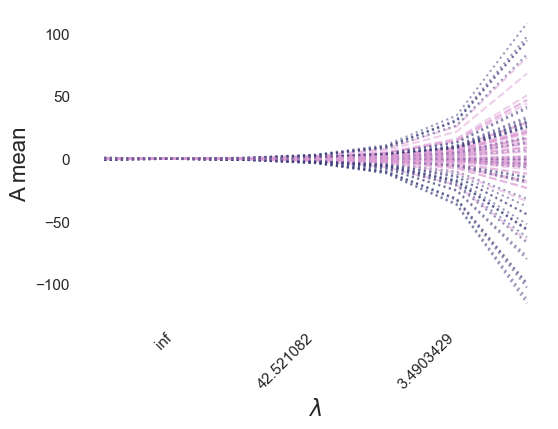

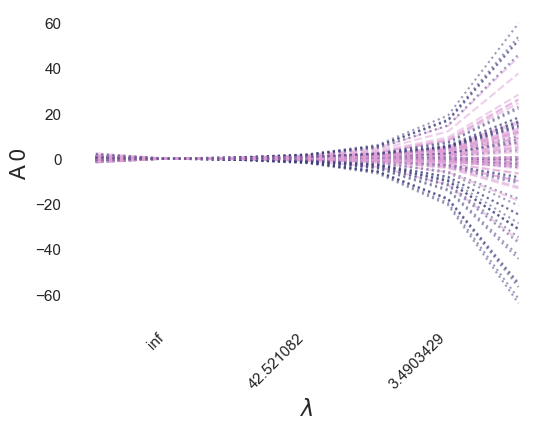

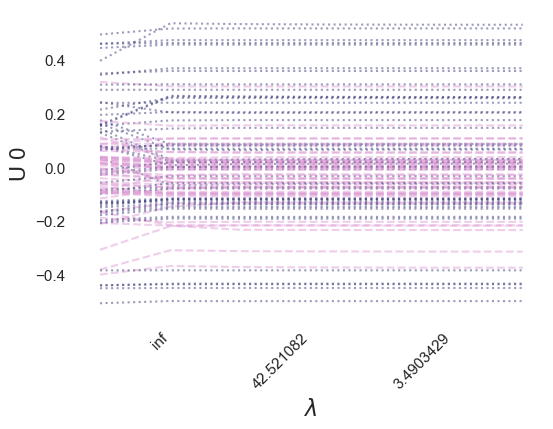

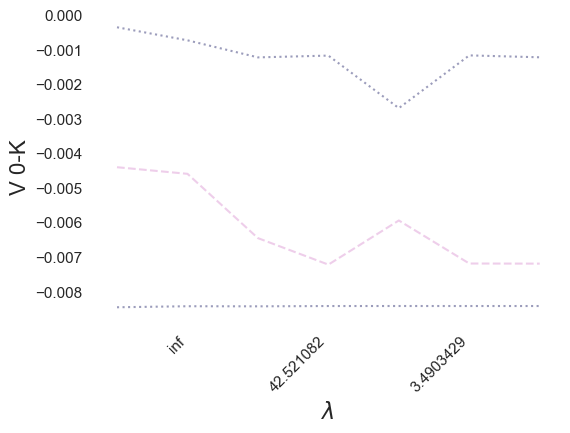

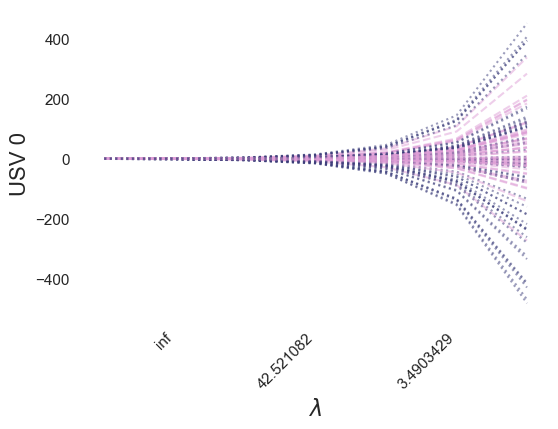

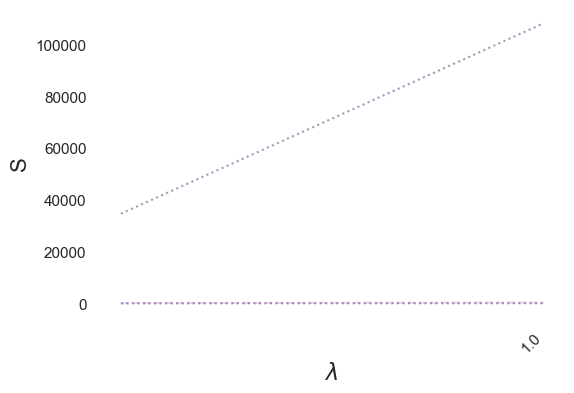

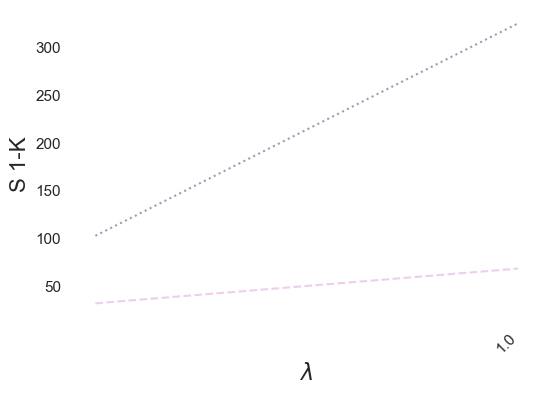

In [45]:
A = A_list
U = U_list
S = s_list
V = V_list

X_compA = []
X_compB = []
UV = []
USV = []
for p in range(len(penalty_list)):
    x_pcmf = U[p]*S[p][:]
    x_pcmf2 = (X_in[:,:] @ V[p].T) 
    X_compA.append(np.array(x_pcmf))
    X_compB.append(np.array(x_pcmf2))
    UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
    USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

X_compA=np.asarray(X_compA)
X_compB=np.asarray(X_compB)

make_plots(A, U, V, S, USV, penalty_list, plot_start=0)


In [46]:
get_clusters(true_clusters_in, X_in, neighbors, A, UV, USV, U, V, S)


Penalty idx 0 ARI 0.07117959409714304 ACC 0.64
Penalty idx 1 ARI 0.08269491587551776 ACC 0.65
Penalty idx 2 ARI -0.0036732295033793712 ACC 0.54
Penalty idx 3 ARI -0.0036732295033793712 ACC 0.54
Penalty idx 4 ARI -0.0036732295033793712 ACC 0.54
Penalty idx 5 ARI -6.530372353668641e-05 ACC 0.55
Penalty idx 6 ARI -6.530372353668641e-05 ACC 0.55
X_c spectral ARI 0.04986068338466051 ACC 0.62 TOC 0.017108917236328125
X_c PCA1 kmeans ARI 0.520623303903631 ACC 0.74 TOC 0.017025232315063477
X_c PCA2 kmeans ARI 0.3114673806569581 ACC 0.76 TOC 0.05629110336303711
X_c kmeans ARI 0.4795361863116003 ACC 0.7 TOC 0.05629110336303711
X_c Ward ARI 0.06277185501066099 ACC 0.7 TOC 0.04146885871887207
